# Synthetic and Real Spectra Comparison
## February 8, 2022

## Step 1: Generate a fake spectral axis

We will begin by initializing the spectral axis we want to use for our synthetic spectrum, which will be between some minimum frequency `fmin` and maximum frequency `fmax`.

In [1]:
from astropy import units as u

fmin = 147.1*u.GHz
fmax = 147.2*u.GHz

In [2]:
import numpy as np

sp_axis = np.linspace(fmin, fmax, 1000)

## Step 2: Generate a synthetic spectrum

With our fake spectral axis, we can generate a synthetic spectrum. We will begin by defining some parameters for the spectrum, i.e. a filling factor and an offset. [should say what these mean]

In [3]:
fillingfactor = 1
offset = 0

Then, we'll define which molecular species we want to include in our synthetic spectrum. This could be expanded to include multiple species, but we'll just use methyl cyanide (CH3CN) for now.

In [4]:
species = 'CH3CN'

Now, we'll get the molecular parameters for this species from Splatalogue. All of the transitions for this molecule between `fmin` and `fmax` will be considered. As an output, the function `get_molecular_parameters` will give us the frequencies, Eistein *A* values, degrees of freedom, and upper-state energies for each of the transitions in the set frequency range, as well as the partition function for that molecule.

In [5]:
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule

freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)

We will now set several parameters that describe the source, so that they can be user-configurated. These values are the central velocity `v_cen`, the velocity dispersion `v_disp`, the temperature `temp`, and the total column density `N_tot`. [can include multiple velocity components]

In [6]:
v_cen = 10*u.km/u.s
v_disp = 1.5*u.km/u.s
temp = 38.32444*u.K
N_tot = (10**(13.71651))*u.cm**-2

Now we can generate model data that incorporates all of these transitions under the conditions we just set. The `generate_model` function takes as inputs the spectral axis we created earlier, several properties of the source (the central velocity, the velocity dispersion, the temperature, and the total column density), and the outputs from our query for molecular parameters. [want units—what are they?]

In [7]:
mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)

We can now build a `pyspeckit.Spectrum` object using this model data and the spectral axis we generated. We can plot this spectrum: it looks like a methyl cyanide ladder!

In [8]:
mod_sp = pyspeckit.Spectrum(xarr=sp_axis.to(u.GHz), data = mod, unit = u.K)

# mod_sp.plotter()

## Step 3: Retrieve a spectrum from the data

First, we'll retrieve the cube that we need.

In [9]:
from spectral_cube import SpectralCube
from astropy import units as u
from lte_modeling_tools import get_molecular_parameters
from astropy import constants

# User inputs
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'

In [10]:
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')

divide by zero encountered in long_scalars


Now, we will extract a spectrum from a particular pixel.

In [11]:
pixel_x, pixel_y = 319, 220
data_sp = ch3cncube[:, pixel_y, pixel_x]

In [12]:
data_sp_K = data_sp.value * ch3cncube.jtok_factors()
data_sp_K_pyspeckit = pyspeckit.Spectrum(xarr = ch3cncube.spectral_axis.to(u.GHz),
                                           data = data_sp_K, unit = u.K)

# data_sp_K_pyspeckit.plotter()

## Step 4: Plot the synthetic and real spectra on the same plot

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

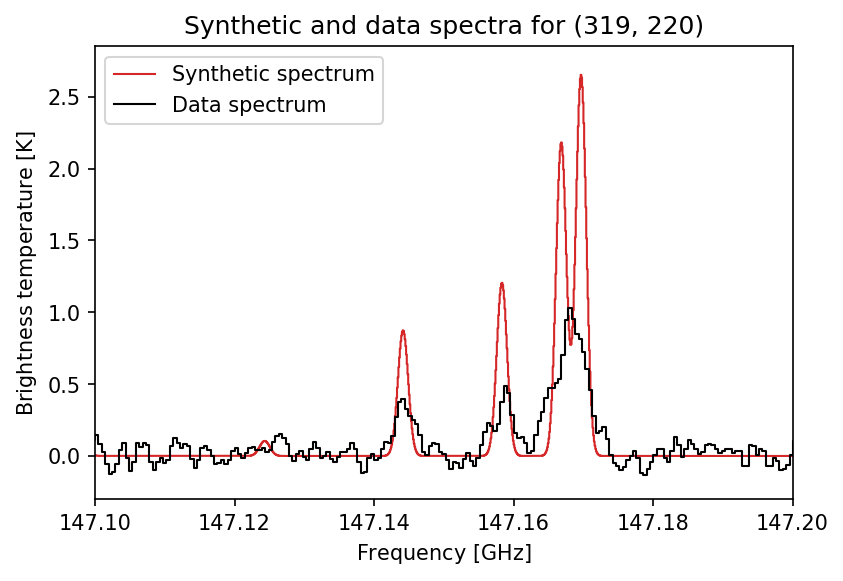

In [14]:
# fig = plt.figure(dpi = display_dpi)
mod_sp.plotter(label = 'Synthetic spectrum', color = 'tab:red', linewidth = 1)
data_sp_K_pyspeckit.plotter(axis=mod_sp.plotter.axis, clear = False, color = 'k', linewidth = 1,
                            xmin = fmin, xmax = fmax, ymin = min(mod) - 0.3, ymax = max(mod) + 0.2, 
                            label = 'Data spectrum', 
                            xlabel = f"Frequency [{mod_sp.xarr.unit.to_string('latex_inline')}]", 
                            ylabel = f"Brightness temperature [{mod_sp.unit.to_string('latex_inline')}]")
plt.title(f"Synthetic and data spectra for ({pixel_x}, {pixel_y})")
plt.legend() # Is this hacking???
data_sp_K_pyspeckit.plotter.savefig('../figures/ch3cn_spec_datasynth.pdf')